In [ ]:
import torch
import os 
os.environ['ROOT_DIR_BRAINTREEBANK'] = '/om2/user/zaho/braintreebank/braintreebank/'

import neuroprobe.config as neuroprobe_config
from neuroprobe.braintreebank_subject import BrainTreebankSubject
from neuroprobe.datasets import BrainTreebankSubjectTrialBenchmarkDataset
import numpy as np

CORRELATION_NEUROPROBE_TASKS = neuroprobe_config.NEUROPROBE_TASKS
# Remove 'onset' and 'speech' from the correlation tasks, because they do not share any variance with the other tasks (labels 0 mean it is not a word, whereas all other tasks are only on words)
CORRELATION_NEUROPROBE_TASKS = [task for task in CORRELATION_NEUROPROBE_TASKS if task not in ['onset', 'speech']]


task_correlations = np.zeros((len(neuroprobe_config.NEUROPROBE_LITE_SUBJECT_TRIALS), len(CORRELATION_NEUROPROBE_TASKS), len(CORRELATION_NEUROPROBE_TASKS)))

coverage_dict = {}
for st_i, (subject_id, trial_id) in enumerate(neuroprobe_config.NEUROPROBE_LITE_SUBJECT_TRIALS):
    subject = BrainTreebankSubject(subject_id, allow_corrupted=False, cache=False, dtype=torch.float32)
    subject.load_neural_data(trial_id)
    
    task_data = {}
    for task_i, task in enumerate(CORRELATION_NEUROPROBE_TASKS):
        dataset = BrainTreebankSubjectTrialBenchmarkDataset(subject, trial_id, torch.float32, task, output_indices=True, lite=True)
        indices_from = []
        labels = []
        for datapoint_i, ((neural_index_from, neural_index_to), label) in enumerate(dataset):
            if neural_index_from in indices_from:
                print(f"Subject {subject_id} trial {trial_id} task {task} has duplicate index: {neural_index_from}")
                continue
            indices_from.append(neural_index_from)
            labels.append(label)
        task_data[task] = {
            "indices_from": indices_from,
            "labels": labels
        }
        print("Completed task", task, "for subject", subject_id, "trial", trial_id)


    for task_a_i, task_a in enumerate(CORRELATION_NEUROPROBE_TASKS):
        for task_b_i, task_b in enumerate(CORRELATION_NEUROPROBE_TASKS):

            labels_a = []
            labels_b = []
            for index_from_a in task_data[task_a]["indices_from"]:
                if index_from_a in task_data[task_b]["indices_from"]:
                    labels_a.append(task_data[task_a]["labels"][ task_data[task_a]["indices_from"].index(index_from_a)])
                    labels_b.append(task_data[task_b]["labels"][ task_data[task_b]["indices_from"].index(index_from_a)])
            
            if len(labels_a) == 0:
                task_correlations[st_i, task_a_i, task_b_i] = np.nan
                continue

            task_correlations[st_i, task_a_i, task_b_i] = np.corrcoef(labels_a, labels_b)[0,1]
            

print(task_correlations)

Completed task volume for subject 1 trial 1
Completed task delta_volume for subject 1 trial 1
Completed task pitch for subject 1 trial 1
Completed task word_index for subject 1 trial 1
Completed task word_gap for subject 1 trial 1
Completed task gpt2_surprisal for subject 1 trial 1
Completed task word_head_pos for subject 1 trial 1
Completed task word_part_speech for subject 1 trial 1
Completed task word_length for subject 1 trial 1
Completed task global_flow for subject 1 trial 1
Completed task local_flow for subject 1 trial 1
Completed task frame_brightness for subject 1 trial 1
Completed task face_num for subject 1 trial 1
Completed task volume for subject 1 trial 2
Completed task delta_volume for subject 1 trial 2
Completed task pitch for subject 1 trial 2
Completed task word_index for subject 1 trial 2
Completed task word_gap for subject 1 trial 2
Completed task gpt2_surprisal for subject 1 trial 2
Completed task word_head_pos for subject 1 trial 2
Completed task word_part_speech 

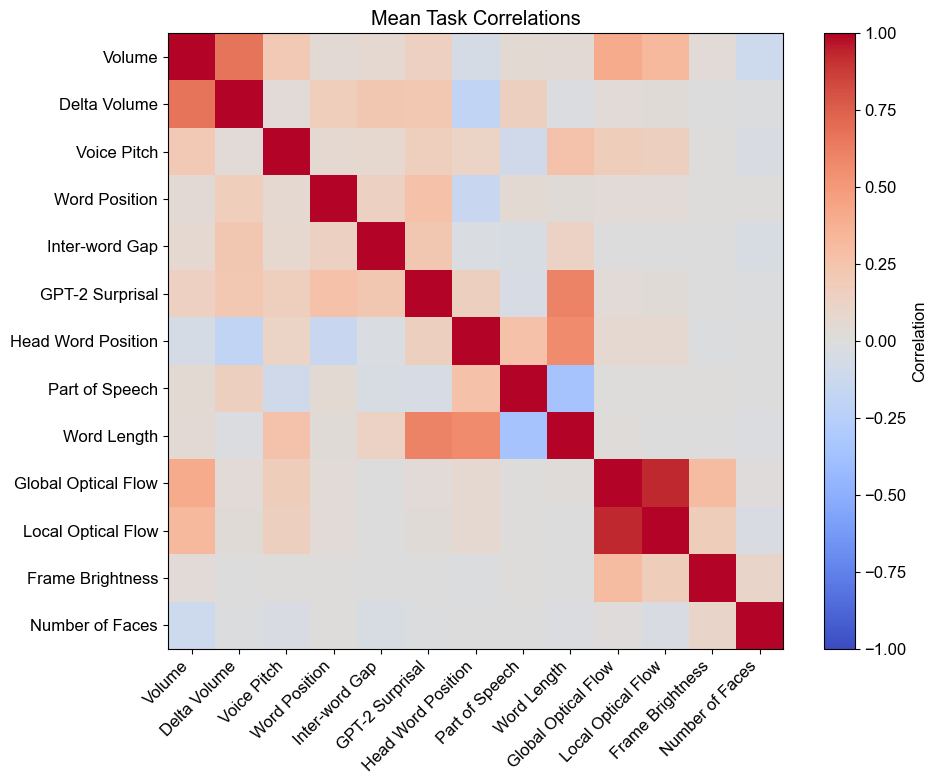

In [6]:
task_correlations # shape (len(neuroprobe_config.NEUROPROBE_LITE_SUBJECT_TRIALS), len(neuroprobe_config.NEUROPROBE_TASKS), len(neuroprobe_config.NEUROPROBE_TASKS)))
mean_task_correlations = np.nanmean(task_correlations, axis=0)


import matplotlib.pyplot as plt
# Add Arial font
import matplotlib.font_manager as fm
font_path = 'analyses/font_arial.ttf'
fm.fontManager.addfont(font_path)
plt.rcParams['font.family'] = 'Arial'
plt.rcParams.update({'font.size': 12})


plt.figure(figsize=(10, 8))
plt.imshow(mean_task_correlations, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar(label='Correlation')

# Add task names as labels
CORRELATION_NEUROPROBE_TASKS_MAPPING = {task: neuroprobe_config.NEUROPROBE_TASKS_MAPPING[task] for task in CORRELATION_NEUROPROBE_TASKS}
plt.xticks(range(len(CORRELATION_NEUROPROBE_TASKS)), CORRELATION_NEUROPROBE_TASKS_MAPPING.values(), rotation=45, ha='right')
plt.yticks(range(len(CORRELATION_NEUROPROBE_TASKS)), CORRELATION_NEUROPROBE_TASKS_MAPPING.values())

plt.title('Mean Task Correlations')
plt.savefig('analyses/figures/task_correlations.pdf', bbox_inches='tight')
plt.tight_layout()
plt.show()

In [10]:
mean_task_correlations = np.nanmean(task_correlations, axis=0)
# Get upper triangle elements using a mask (excluding diagonal)
mask = np.triu(np.ones_like(mean_task_correlations, dtype=bool), k=1)
off_diag_correlations = np.abs(mean_task_correlations[mask])
# Calculate mean and SEM of off-diagonal elements
mean_off_diag = np.nanmean(off_diag_correlations)
sem_off_diag = np.nanstd(off_diag_correlations) / np.sqrt(np.sum(~np.isnan(off_diag_correlations)))

print(f"Mean absolute off-diagonal correlation: {mean_off_diag:.3f} ± {sem_off_diag:.3f}")

Mean absolute off-diagonal correlation: 0.121 ± 0.019
